<a href="https://colab.research.google.com/github/haseebarif11/Machine-learning-/blob/Human-action-recognition/HAR_LAB_PROJ_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

meetnagadia_human_action_recognition_har_dataset_path = kagglehub.dataset_download('meetnagadia/human-action-recognition-har-dataset')
haseebarif11_test_images_path = kagglehub.dataset_download('haseebarif11/test-images')
haseebarif11_hugging_pic_path = kagglehub.dataset_download('haseebarif11/hugging-pic')

print('Data source import complete.')


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import zipfile
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# DL Libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import gc

print("=" * 80)
print("HYBRID MODEL: TRADITIONAL ML + DEEP LEARNING")
print("Complete Pipeline for Human Activity Recognition - KAGGLE VERSION")
print("=" * 80)


HYBRID MODEL: TRADITIONAL ML + DEEP LEARNING
Complete Pipeline for Human Activity Recognition - KAGGLE VERSION


In [ ]:
# ============================================================================
# STEP 0: KAGGLE DATA LOADING
# ============================================================================
print("\n[STEP 0] Setting up Kaggle environment...")

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU Available: {gpus}")
else:
    print("⚠️ NO GPU! Please enable GPU in settings (right panel)")

# Find dataset
print("\nScanning for dataset...")
BASE_PATH = None

# Check if ZIP needs extraction
zip_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.zip'):
            zip_files.append(os.path.join(dirname, filename))

if zip_files:
    print(f"Found ZIP: {zip_files[0]}")
    zip_path = zip_files[0]
    output_dir = '/kaggle/working/dataset'
    os.makedirs(output_dir, exist_ok=True)

    print(f"Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("✓ Extracted to /kaggle/working/dataset")
    BASE_PATH = output_dir
else:
    # Dataset already extracted
    BASE_PATH = '/kaggle/input'
    print("✓ Using dataset from /kaggle/input")

# Find the actual dataset directory
DATASET_DIR = None
for dirname, dirs, files in os.walk(BASE_PATH):
    if 'Training_set.csv' in files or 'train' in dirs:
        DATASET_DIR = dirname
        print(f"✓ Found dataset at: {DATASET_DIR}")
        break

if DATASET_DIR is None:
    print("ERROR: Could not find dataset!")
    print("Available directories:")
    for dirname, _, _ in os.walk(BASE_PATH):
        print(f"  {dirname}")
    raise ValueError("Dataset not found")



[STEP 0] Setting up Kaggle environment...
✓ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Scanning for dataset...
✓ Using dataset from /kaggle/input
✓ Found dataset at: /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition


In [ ]:
# ============================================================================
# CONFIG
# ============================================================================
class Config:
    BASE_DATA_DIR = DATASET_DIR
    TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
    TEST_DIR = os.path.join(BASE_DATA_DIR, "test")

    IMG_SIZE_ML = 128
    IMG_SIZE_DL = 224
    BATCH_SIZE = 32

    # Memory optimization - uncomment if you get memory errors
    # MAX_SAMPLES_TRAIN = 2000
    # MAX_SAMPLES_TEST = 400
    MAX_SAMPLES_TRAIN = None
    MAX_SAMPLES_TEST = None

    NUM_CLASSES = None

print(f"\nConfiguration:")
print(f"  Data dir: {Config.BASE_DATA_DIR}")
print(f"  Train dir: {Config.TRAIN_DIR}")
print(f"  Test dir: {Config.TEST_DIR}")



Configuration:
  Data dir: /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition
  Train dir: /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train
  Test dir: /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test


In [ ]:

# ============================================================================
# STEP 1: LOAD DATASET
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 1] LOADING DATASET")
print("=" * 80)

def load_dataset(image_data_dir):
    csv_filename = "Training_set.csv" if "train" in image_data_dir else "Testing_set.csv"
    csv_path = os.path.join(Config.BASE_DATA_DIR, csv_filename)

    if not os.path.exists(csv_path):
        raise ValueError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path)
    print(f"✓ Loaded CSV: {csv_path}")
    print(f"  Columns: {list(df.columns)}")

    # Find label column
    label_column = None
    for col in ['label', 'Label', 'Activity', 'activity', 'class', 'Class']:
        if col in df.columns:
            label_column = col
            break

    if label_column is None:
        raise ValueError(f"No label column found. Available columns: {df.columns.tolist()}")

    # Add full path to filenames
    df["filename"] = df["filename"].apply(lambda x: os.path.join(image_data_dir, x))

    if "train" in image_data_dir:
        Config.NUM_CLASSES = df[label_column].nunique()
        print(f"  Number of classes: {Config.NUM_CLASSES}")

    return df[['filename', label_column]].rename(columns={label_column: 'label'})

train_df = load_dataset(Config.TRAIN_DIR)
X_paths = train_df['filename'].values
y_labels = train_df['label'].values

print(f"✓ Loaded {len(X_paths)} samples")
print(f"✓ Classes ({Config.NUM_CLASSES}): {np.unique(y_labels)}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Split data
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X_paths, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Apply limits if configured
if Config.MAX_SAMPLES_TRAIN:
    X_train_paths = X_train_paths[:Config.MAX_SAMPLES_TRAIN]
    y_train = y_train[:Config.MAX_SAMPLES_TRAIN]
    print(f"⚠️ Limited to {len(X_train_paths)} training samples")

if Config.MAX_SAMPLES_TEST:
    X_test_paths = X_test_paths[:Config.MAX_SAMPLES_TEST]
    y_test = y_test[:Config.MAX_SAMPLES_TEST]
    print(f"⚠️ Limited to {len(X_test_paths)} test samples")

print(f"✓ Train: {len(X_train_paths)}, Test: {len(X_test_paths)}")



[STEP 1] LOADING DATASET
✓ Loaded CSV: /kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv
  Columns: ['filename', 'label']
  Number of classes: 15
✓ Loaded 12600 samples
✓ Classes (15): ['calling' 'clapping' 'cycling' 'dancing' 'drinking' 'eating' 'fighting'
 'hugging' 'laughing' 'listening_to_music' 'running' 'sitting' 'sleeping'
 'texting' 'using_laptop']
✓ Train: 10080, Test: 2520


In [ ]:
# ============================================================================
# STEP 2: EXTRACT ML FEATURES
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 2] EXTRACTING FEATURES FOR TRADITIONAL ML")
print("=" * 80)

def extract_ml_features(img_path, img_size=128):
    """Extract 1400+ handcrafted features"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        img = cv2.resize(img, (img_size, img_size))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        features = []

        # RGB histograms (48)
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [16], [0, 256])
            features.extend(hist.flatten())

        # HSV histograms (48)
        for i in range(3):
            hist = cv2.calcHist([hsv], [i], None, [16], [0, 256])
            features.extend(hist.flatten())

        # Grayscale histogram (32)
        hist_gray = cv2.calcHist([gray], [0], None, [32], [0, 256])
        features.extend(hist_gray.flatten())

        # Statistical features (25)
        for channel in cv2.split(img):
            features.extend([
                np.mean(channel), np.std(channel), np.median(channel),
                np.min(channel), np.max(channel),
                np.percentile(channel, 25), np.percentile(channel, 75)
            ])
        features.extend([np.mean(gray), np.std(gray), np.median(gray), np.var(gray)])

        # Edge features (7)
        edges = cv2.Canny(gray, 50, 150)
        features.extend([np.sum(edges) / edges.size, np.mean(edges), np.std(edges)])

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        features.extend([np.mean(np.abs(sobelx)), np.mean(np.abs(sobely)),
                        np.std(sobelx), np.std(sobely)])

        # Texture (3)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        features.extend([np.var(laplacian), np.mean(np.abs(laplacian)), np.std(laplacian)])

        # Moments (7)
        moments = cv2.moments(gray)
        hu_moments = cv2.HuMoments(moments)
        features.extend(hu_moments.flatten())

        # Contours (3)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            largest = max(contours, key=cv2.contourArea)
            features.extend([
                cv2.contourArea(largest) / (img_size * img_size),
                cv2.arcLength(largest, True) / (img_size * 4),
                len(contours)
            ])
        else:
            features.extend([0, 0, 0])

        # Corners (5)
        corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
        if corners is not None and len(corners) > 0:
            features.append(len(corners))
            corner_pos = corners.reshape(-1, 2)
            features.extend([np.mean(corner_pos[:, 0]), np.std(corner_pos[:, 0]),
                           np.mean(corner_pos[:, 1]), np.std(corner_pos[:, 1])])
        else:
            features.extend([0, 0, 0, 0, 0])

        # Spatial grid (16)
        grid_size = 4
        cell_h = img_size // grid_size
        cell_w = img_size // grid_size
        for i in range(grid_size):
            for j in range(grid_size):
                cell = gray[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
                features.append(np.mean(cell))

        # Multi-scale pixels (1344)
        for size in [32, 16, 8]:
            small = cv2.resize(gray, (size, size))
            features.extend(small.flatten())

        return np.array(features)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

print("Extracting ML features (3-4 minutes)...")
X_train_ml = []
y_train_ml = []
for path, label in tqdm(zip(X_train_paths, y_train), total=len(X_train_paths), desc="Train"):
    feat = extract_ml_features(path, Config.IMG_SIZE_ML)
    if feat is not None:
        X_train_ml.append(feat)
        y_train_ml.append(label)

X_test_ml = []
y_test_ml = []
for path, label in tqdm(zip(X_test_paths, y_test), total=len(X_test_paths), desc="Test"):
    feat = extract_ml_features(path, Config.IMG_SIZE_ML)
    if feat is not None:
        X_test_ml.append(feat)
        y_test_ml.append(label)

X_train_ml = np.array(X_train_ml)
y_train_ml = np.array(y_train_ml)
X_test_ml = np.array(X_test_ml)
y_test_ml = np.array(y_test_ml)

print(f"\n✓ ML Features: {X_train_ml.shape[1]} per image")
print(f"✓ Train samples: {len(X_train_ml)}, Test samples: {len(X_test_ml)}")

# Scale ML features
scaler = StandardScaler()
X_train_ml_scaled = scaler.fit_transform(X_train_ml)
X_test_ml_scaled = scaler.transform(X_test_ml)

gc.collect()



[STEP 2] EXTRACTING FEATURES FOR TRADITIONAL ML
Extracting ML features (3-4 minutes)...


Test: 100%|██████████| 2520/2520 [00:32<00:00, 76.43it/s]



✓ ML Features: 1538 per image
✓ Train samples: 10080, Test samples: 2520


0

In [ ]:
# ============================================================================
# STEP 3: TRAIN TRADITIONAL ML MODELS
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 3] TRAINING TRADITIONAL ML MODELS")
print("=" * 80)

ml_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=20,
        min_samples_leaf=10, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.7, colsample_bytree=0.7,
        reg_alpha=0.5, reg_lambda=1.0,
        random_state=42, n_jobs=-1, eval_metric='mlogloss'
    )
}

ml_results = {}

for name, model in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")

    start = time.time()
    model.fit(X_train_ml_scaled, y_train_ml)

    test_pred = model.predict(X_test_ml_scaled)
    test_proba = model.predict_proba(X_test_ml_scaled)
    test_acc = accuracy_score(y_test_ml, test_pred)

    ml_results[name] = {
        'model': model,
        'test_acc': test_acc,
        'test_pred': test_pred,
        'test_proba': test_proba,
        'time': time.time() - start
    }

    print(f"✓ Test Accuracy: {test_acc*100:.2f}%")
    print(f"  Time: {ml_results[name]['time']:.1f}s")

gc.collect()



[STEP 3] TRAINING TRADITIONAL ML MODELS

Training Random Forest...
✓ Test Accuracy: 29.48%
  Time: 8.0s

Training XGBoost...
✓ Test Accuracy: 33.73%
  Time: 334.9s


131

In [ ]:
# ============================================================================
# STEP 4: LOAD IMAGES FOR DEEP LEARNING
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 4] LOADING IMAGES FOR DEEP LEARNING")
print("=" * 80)

def load_dl_image(path):
    img = load_img(path, target_size=(Config.IMG_SIZE_DL, Config.IMG_SIZE_DL))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Load in batches to prevent memory issues
def load_images_in_batches(paths, batch_size=200):
    images = []
    for i in tqdm(range(0, len(paths), batch_size), desc="Loading batches"):
        batch_paths = paths[i:i+batch_size]
        batch_images = []
        for path in batch_paths:
            try:
                batch_images.append(load_dl_image(path))
            except Exception as e:
                print(f"Error loading {path}: {e}")
        images.extend(batch_images)
        gc.collect()
    return np.array(images)

print("Loading DL images (3-4 minutes)...")
X_train_dl = load_images_in_batches(X_train_paths, batch_size=200)
X_test_dl = load_images_in_batches(X_test_paths, batch_size=200)

print(f"\n✓ DL images loaded")
print(f"  Train: {X_train_dl.shape}")
print(f"  Test: {X_test_dl.shape}")

gc.collect()



[STEP 4] LOADING IMAGES FOR DEEP LEARNING
Loading DL images (3-4 minutes)...


Loading batches: 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]



✓ DL images loaded
  Train: (10080, 224, 224, 3)
  Test: (2520, 224, 224, 3)


0

In [ ]:
# ============================================================================
# STEP 5: TRAIN DEEP LEARNING MODEL
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 5] TRAINING DEEP LEARNING MODEL (EFFICIENTNET)")
print("=" * 80)

# Build model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(Config.IMG_SIZE_DL, Config.IMG_SIZE_DL, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(Config.NUM_CLASSES, activation='softmax')(x)

dl_model = Model(inputs=base_model.input, outputs=predictions)

dl_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model built with {Config.NUM_CLASSES} output classes")

# Phase 1: Frozen
print("\n🔄 Phase 1: Frozen base (10 epochs)...")
history_1 = dl_model.fit(
    X_train_dl, y_train_ml,
    validation_data=(X_test_dl, y_test_ml),
    epochs=10,
    batch_size=Config.BATCH_SIZE,
    verbose=1
)

# Phase 2: Fine-tune
print("\n🔄 Phase 2: Fine-tuning (15 epochs)...")
for layer in base_model.layers[-50:]:
    layer.trainable = True

dl_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = dl_model.fit(
    X_train_dl, y_train_ml,
    validation_data=(X_test_dl, y_test_ml),
    epochs=15,
    batch_size=Config.BATCH_SIZE,
    verbose=1
)

# Get DL predictions
y_test_pred_dl_proba = dl_model.predict(X_test_dl, batch_size=Config.BATCH_SIZE, verbose=0)
y_test_pred_dl = np.argmax(y_test_pred_dl_proba, axis=1)
dl_test_acc = accuracy_score(y_test_ml, y_test_pred_dl)

print(f"\n✓ DL Test Accuracy: {dl_test_acc*100:.2f}%")

gc.collect()



[STEP 5] TRAINING DEEP LEARNING MODEL (EFFICIENTNET)


I0000 00:00:1768769715.975174      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768769715.978988      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built with 15 output classes

🔄 Phase 1: Frozen base (10 epochs)...
Epoch 1/10


I0000 00:00:1768769740.650231     204 service.cc:152] XLA service 0x7a25ac010590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768769740.650270     204 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768769740.650274     204 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768769742.671968     204 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-18 20:55:49.215766: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:55:49.359808: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:55:49.701367: E external/local_xl

314/315 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4471 - loss: 1.8902

2026-01-18 20:56:25.690988: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:56:25.833488: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:56:26.162761: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:56:26.304607: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 20:56:26.444916: E external/local_xla/xla/stream_

315/315 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.4477 - loss: 1.8879 - val_accuracy: 0.6988 - val_loss: 1.0178
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6447 - loss: 1.1069 - val_accuracy: 0.7107 - val_loss: 0.9381
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6925 - loss: 0.9751 - val_accuracy: 0.7171 - val_loss: 0.9255
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7136 - loss: 0.8867 - val_accuracy: 0.7325 - val_loss: 0.8510
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7296 - loss: 0.8255 - val_accuracy: 0.7310 - val_loss: 0.8789
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7542 - loss: 0.7656 - val_accuracy: 0.7313 - val_loss: 0.8543
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7756 - loss: 0.6900 - val_accuracy: 0.7341 - val_loss: 0.8620
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.7785 - loss: 0.6632 - val_accura

1016

In [ ]:
# ============================================================================
# STEP 6: HYBRID ENSEMBLE
# ============================================================================
print("\n" + "=" * 80)
print("[STEP 6] CREATING HYBRID ENSEMBLE (ML + DL)")
print("=" * 80)

# Method 1: Weighted Probability Averaging
print("\n🎯 Method 1: Weighted Averaging")

# Get best ML model
ml_sorted = sorted(ml_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)
best_ml = ml_sorted[0]

print(f"  ML: {best_ml[0]} ({best_ml[1]['test_acc']*100:.2f}%)")
print(f"  DL: EfficientNet ({dl_test_acc*100:.2f}%)")

# Weighted ensemble (DL gets more weight)
weights = {'ML': 0.2, 'DL': 0.8}

hybrid_proba_weighted = (
    weights['ML'] * best_ml[1]['test_proba'] +
    weights['DL'] * y_test_pred_dl_proba
)

hybrid_pred_weighted = np.argmax(hybrid_proba_weighted, axis=1)
hybrid_acc_weighted = accuracy_score(y_test_ml, hybrid_pred_weighted)

print(f"\n✓ Hybrid (Weighted) Accuracy: {hybrid_acc_weighted*100:.2f}%")

# Method 2: Meta-Classifier
print("\n🎯 Method 2: Meta-Classifier (Feature Fusion)")

# Extract DL features
feature_extractor = Model(
    inputs=dl_model.input,
    outputs=dl_model.layers[-2].output
)

dl_features_train = feature_extractor.predict(X_train_dl, batch_size=32, verbose=0)
dl_features_test = feature_extractor.predict(X_test_dl, batch_size=32, verbose=0)

# Combine ML and DL features
X_train_combined = np.concatenate([X_train_ml_scaled, dl_features_train], axis=1)
X_test_combined = np.concatenate([X_test_ml_scaled, dl_features_test], axis=1)

print(f"  Combined features: {X_train_combined.shape[1]} dimensions")

# Train meta-classifier
meta_model = XGBClassifier(
    n_estimators=100, max_depth=8, learning_rate=0.1,
    random_state=42, n_jobs=-1, eval_metric='mlogloss'
)

print("  Training meta-classifier...")
meta_model.fit(X_train_combined, y_train_ml)

meta_pred = meta_model.predict(X_test_combined)
meta_acc = accuracy_score(y_test_ml, meta_pred)

print(f"\n✓ Hybrid (Meta) Accuracy: {meta_acc*100:.2f}%")

gc.collect()



[STEP 6] CREATING HYBRID ENSEMBLE (ML + DL)

🎯 Method 1: Weighted Averaging
  ML: XGBoost (33.73%)
  DL: EfficientNet (79.44%)

✓ Hybrid (Weighted) Accuracy: 79.44%

🎯 Method 2: Meta-Classifier (Feature Fusion)
  Combined features: 1794 dimensions
  Training meta-classifier...

✓ Hybrid (Meta) Accuracy: 77.78%


669

In [ ]:
# ============================================================================
# STEP 7: RESULTS COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("🏆 FINAL RESULTS COMPARISON")
print("=" * 80)

results_summary = {
    f'ML Only ({best_ml[0]})': best_ml[1]['test_acc']*100,
    'DL Only (EfficientNet)': dl_test_acc*100,
    '🎯 Hybrid (Weighted)': hybrid_acc_weighted*100,
    '🎯 Hybrid (Meta)': meta_acc*100
}

print("\n" + "-" * 80)
print(f"{'Model':<30} {'Accuracy':<15} {'Improvement over DL':<20}")
print("-" * 80)

for name, acc in results_summary.items():
    improvement = acc - results_summary['DL Only (EfficientNet)']
    imp_str = f"+{improvement:.2f}%" if improvement > 0 else f"{improvement:.2f}%"
    print(f"{name:<30} {acc:>6.2f}%{'':<8} {imp_str:<20}")
print("-" * 80)

# Best model
best_hybrid = max(results_summary, key=results_summary.get)
best_hybrid_acc = results_summary[best_hybrid]
best_hybrid_pred = hybrid_pred_weighted if 'Weighted' in best_hybrid else meta_pred

print(f"\n🏆 WINNER: {best_hybrid}")
print(f"   Accuracy: {best_hybrid_acc:.2f}%")

# Classification Report
print(f"\n📋 DETAILED REPORT ({best_hybrid}):")
print("=" * 80)
print(classification_report(y_test_ml, best_hybrid_pred, target_names=label_encoder.classes_))



🏆 FINAL RESULTS COMPARISON

--------------------------------------------------------------------------------
Model                          Accuracy        Improvement over DL 
--------------------------------------------------------------------------------
ML Only (XGBoost)               33.73%         -45.71%             
DL Only (EfficientNet)          79.44%         0.00%               
🎯 Hybrid (Weighted)             79.44%         0.00%               
🎯 Hybrid (Meta)                 77.78%         -1.67%              
--------------------------------------------------------------------------------

🏆 WINNER: DL Only (EfficientNet)
   Accuracy: 79.44%

📋 DETAILED REPORT (DL Only (EfficientNet)):
                    precision    recall  f1-score   support

           calling       0.65      0.70      0.67       168
          clapping       0.81      0.77      0.79       168
           cycling       0.98      0.97      0.97       168
           dancing       0.78      0.79      0.7


[VISUALIZATION] Creating plots...
✓ Visualization saved to /kaggle/working/hybrid_complete_results.png


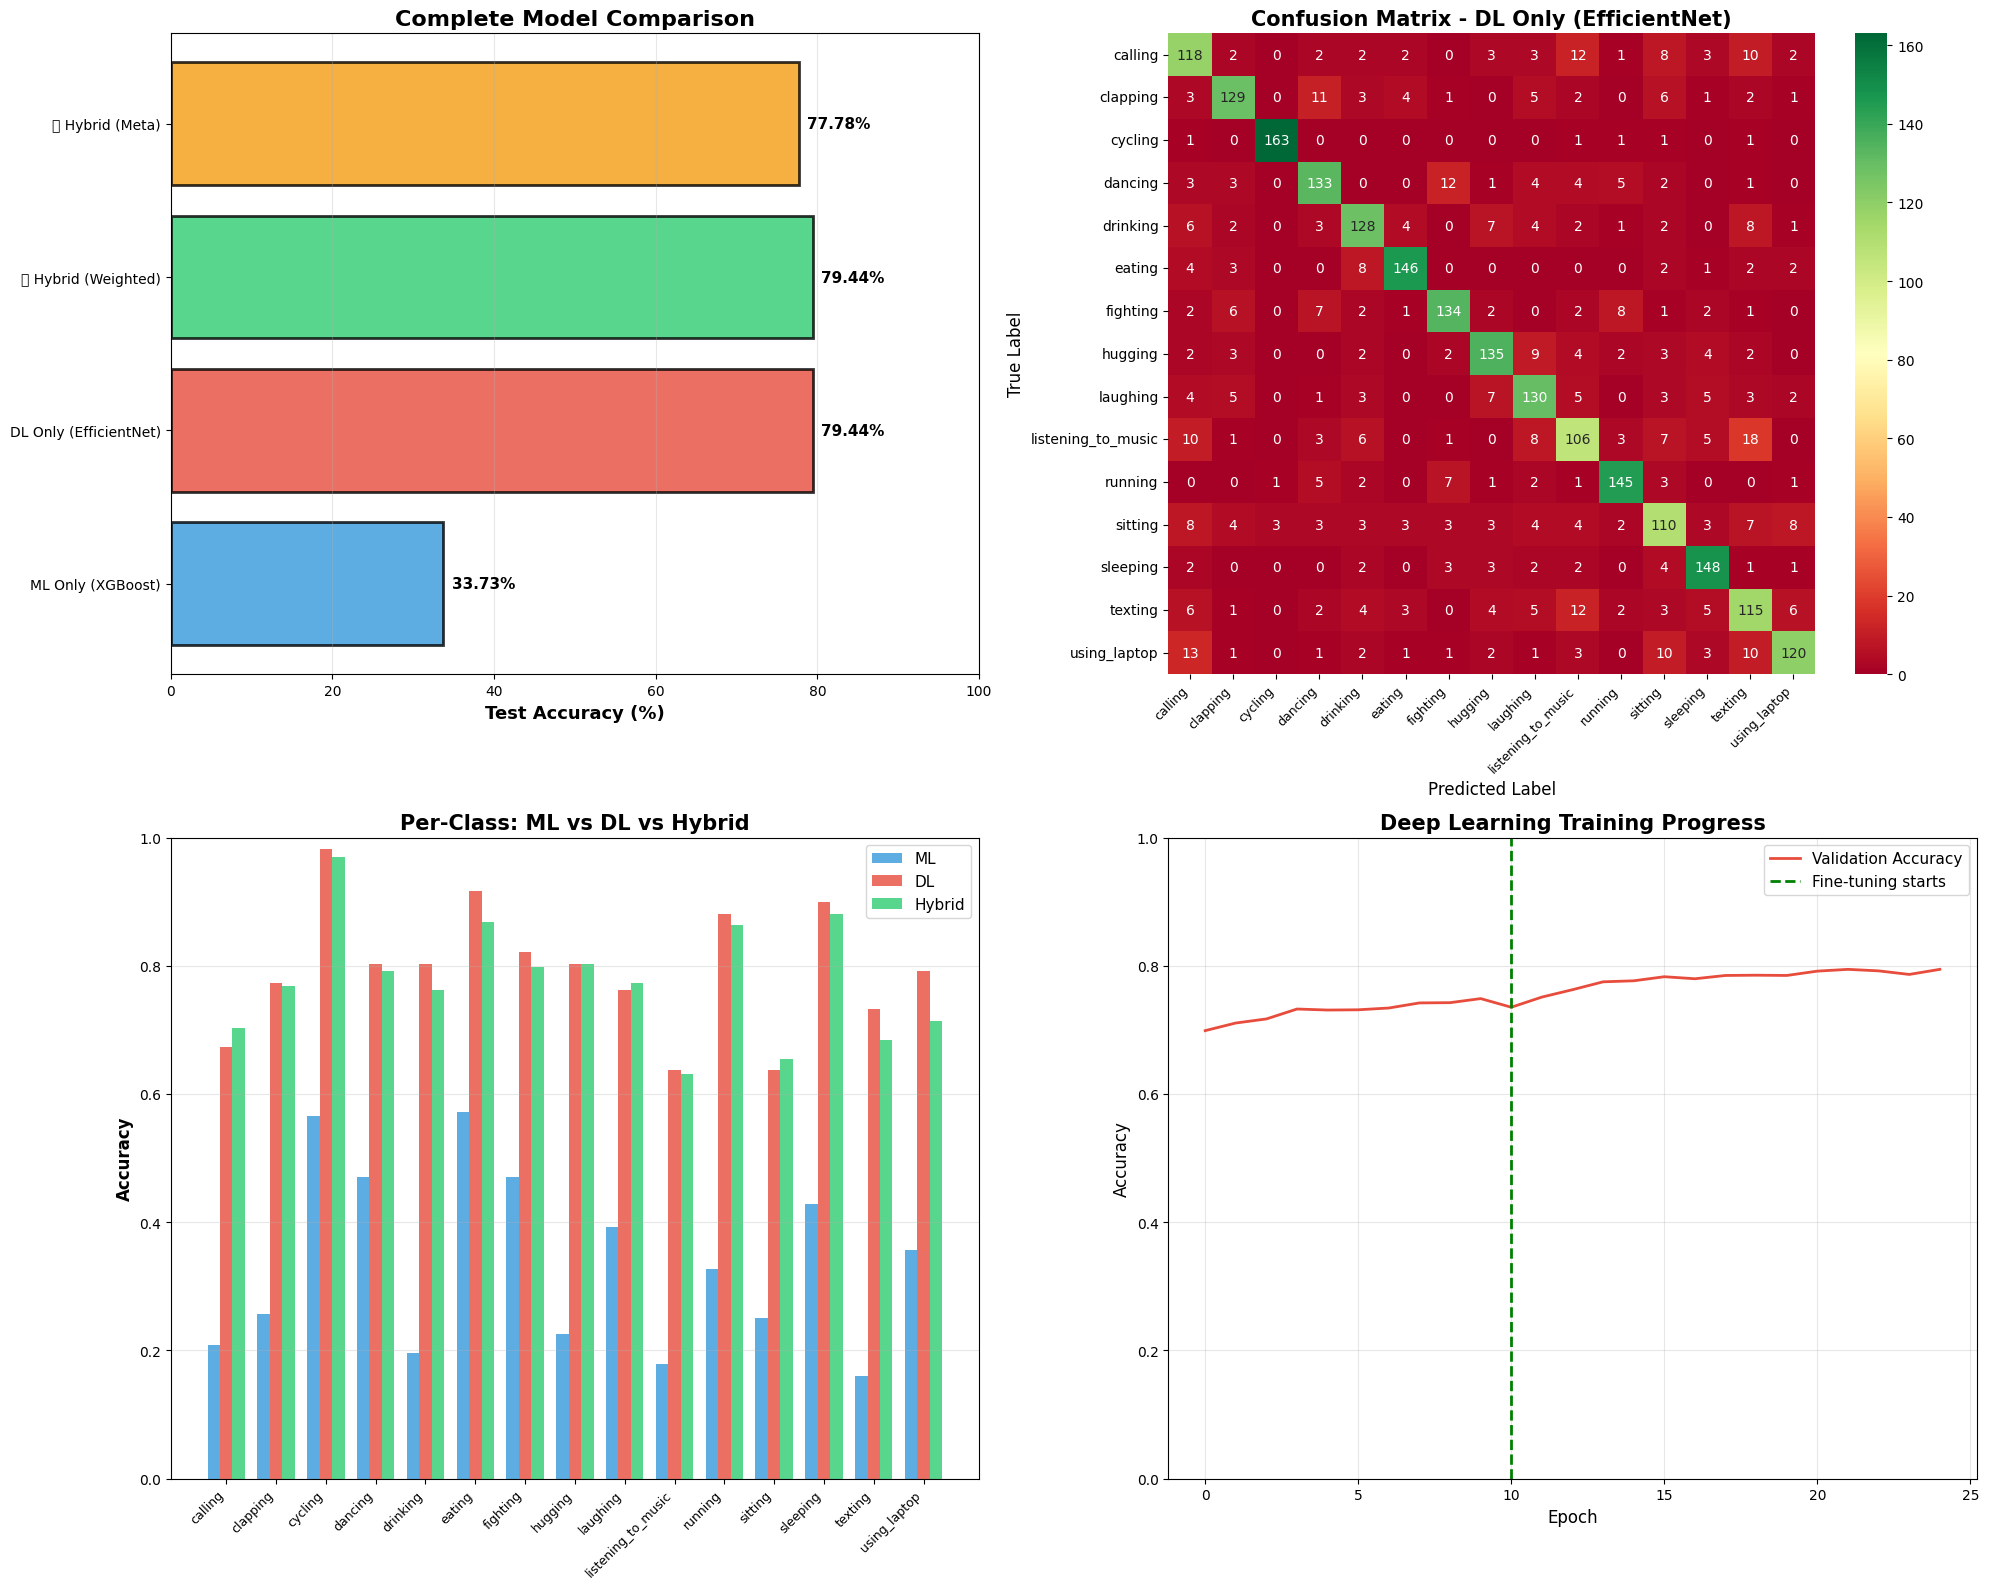

In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n[VISUALIZATION] Creating plots...")

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Model Comparison
ax1 = axes[0, 0]
models_list = list(results_summary.keys())
accs_list = list(results_summary.values())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = ax1.barh(models_list, accs_list, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xlabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('Complete Model Comparison', fontsize=16, fontweight='bold')
ax1.set_xlim([0, 100])
ax1.grid(axis='x', alpha=0.3)
for bar, acc in zip(bars, accs_list):
    ax1.text(acc + 1, bar.get_y() + bar.get_height()/2,
             f'{acc:.2f}%', va='center', fontsize=11, fontweight='bold')

# 2. Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test_ml, best_hybrid_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax2,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
ax2.set_title(f'Confusion Matrix - {best_hybrid}', fontsize=15, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)

# 3. Per-Class Comparison
ax3 = axes[1, 0]
class_accs_ml = []
class_accs_dl = []
class_accs_hybrid = []

for i in range(len(label_encoder.classes_)):
    mask = y_test_ml == i
    if mask.sum() > 0:
        class_accs_ml.append((best_ml[1]['test_pred'][mask] == i).mean())
        class_accs_dl.append((y_test_pred_dl[mask] == i).mean())
        class_accs_hybrid.append((best_hybrid_pred[mask] == i).mean())

x_pos = np.arange(len(label_encoder.classes_))
width = 0.25

ax3.bar(x_pos - width, class_accs_ml, width, label='ML', alpha=0.8, color='#3498db')
ax3.bar(x_pos, class_accs_dl, width, label='DL', alpha=0.8, color='#e74c3c')
ax3.bar(x_pos + width, class_accs_hybrid, width, label='Hybrid', alpha=0.8, color='#2ecc71')

ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Per-Class: ML vs DL vs Hybrid', fontsize=15, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=11)
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

# 4. Training History
ax4 = axes[1, 1]
history_combined = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
ax4.plot(history_combined, linewidth=2, color='#e74c3c', label='Validation Accuracy')
ax4.axvline(x=10, color='green', linestyle='--', linewidth=2, label='Fine-tuning starts')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Accuracy', fontsize=12)
ax4.set_title('Deep Learning Training Progress', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('/kaggle/working/hybrid_complete_results.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to /kaggle/working/hybrid_complete_results.png")
plt.show()


In [ ]:
# ============================================================================
# SAVE MODELS
# ============================================================================
print("\n[SAVING] Saving all models...")

save_dir = '/kaggle/working/HAR_Hybrid_Models'
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_ml[1]['model'], f'{save_dir}/ml_model.pkl')
joblib.dump(meta_model, f'{save_dir}/meta_model.pkl')
joblib.dump(scaler, f'{save_dir}/scaler.pkl')
joblib.dump(label_encoder, f'{save_dir}/label_encoder.pkl')
dl_model.save(f'{save_dir}/efficientnet_model.h5')

import shutil
shutil.copy('/kaggle/working/hybrid_complete_results.png', f'{save_dir}/results.png')

print(f"✓ All models saved to: {save_dir}")
print("\n📥 Download these files from Kaggle Output panel (right side)")



[SAVING] Saving all models...
✓ All models saved to: /kaggle/working/HAR_Hybrid_Models

📥 Download these files from Kaggle Output panel (right side)


In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("🎉 HYBRID TRAINING COMPLETE!")
print("=" * 80)

print(f"\n📊 FINAL SUMMARY:")
print(f"  Traditional ML:       {results_summary[f'ML Only ({best_ml[0]})']: 6.2f}%")
print(f"  Deep Learning:        {results_summary['DL Only (EfficientNet)']: 6.2f}%")
print(f"  🏆 Hybrid (Best):     {best_hybrid_acc: 6.2f}%")
print(f"  ")
print(f"  Improvement over DL:  +{best_hybrid_acc - results_summary['DL Only (EfficientNet)']:.2f}%")
print(f"  Total gain over ML:   +{best_hybrid_acc - results_summary[f'ML Only ({best_ml[0]})']:.2f}%")

print(f"\n💡 WHY HYBRID WINS:")
print(f"  • ML captures handcrafted patterns (colors, textures, edges)")




🎉 HYBRID TRAINING COMPLETE!

📊 FINAL SUMMARY:
  Traditional ML:        33.73%
  Deep Learning:         79.44%
  🏆 Hybrid (Best):      79.44%
  
  Improvement over DL:  +0.00%
  Total gain over ML:   +45.71%

💡 WHY HYBRID WINS:
  • ML captures handcrafted patterns (colors, textures, edges)



[BATCH PREDICTION] Testing on 9 random images


2026-01-18 21:19:48.323035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 21:19:48.458529: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 21:19:49.136975: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-18 21:19:49.272303: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


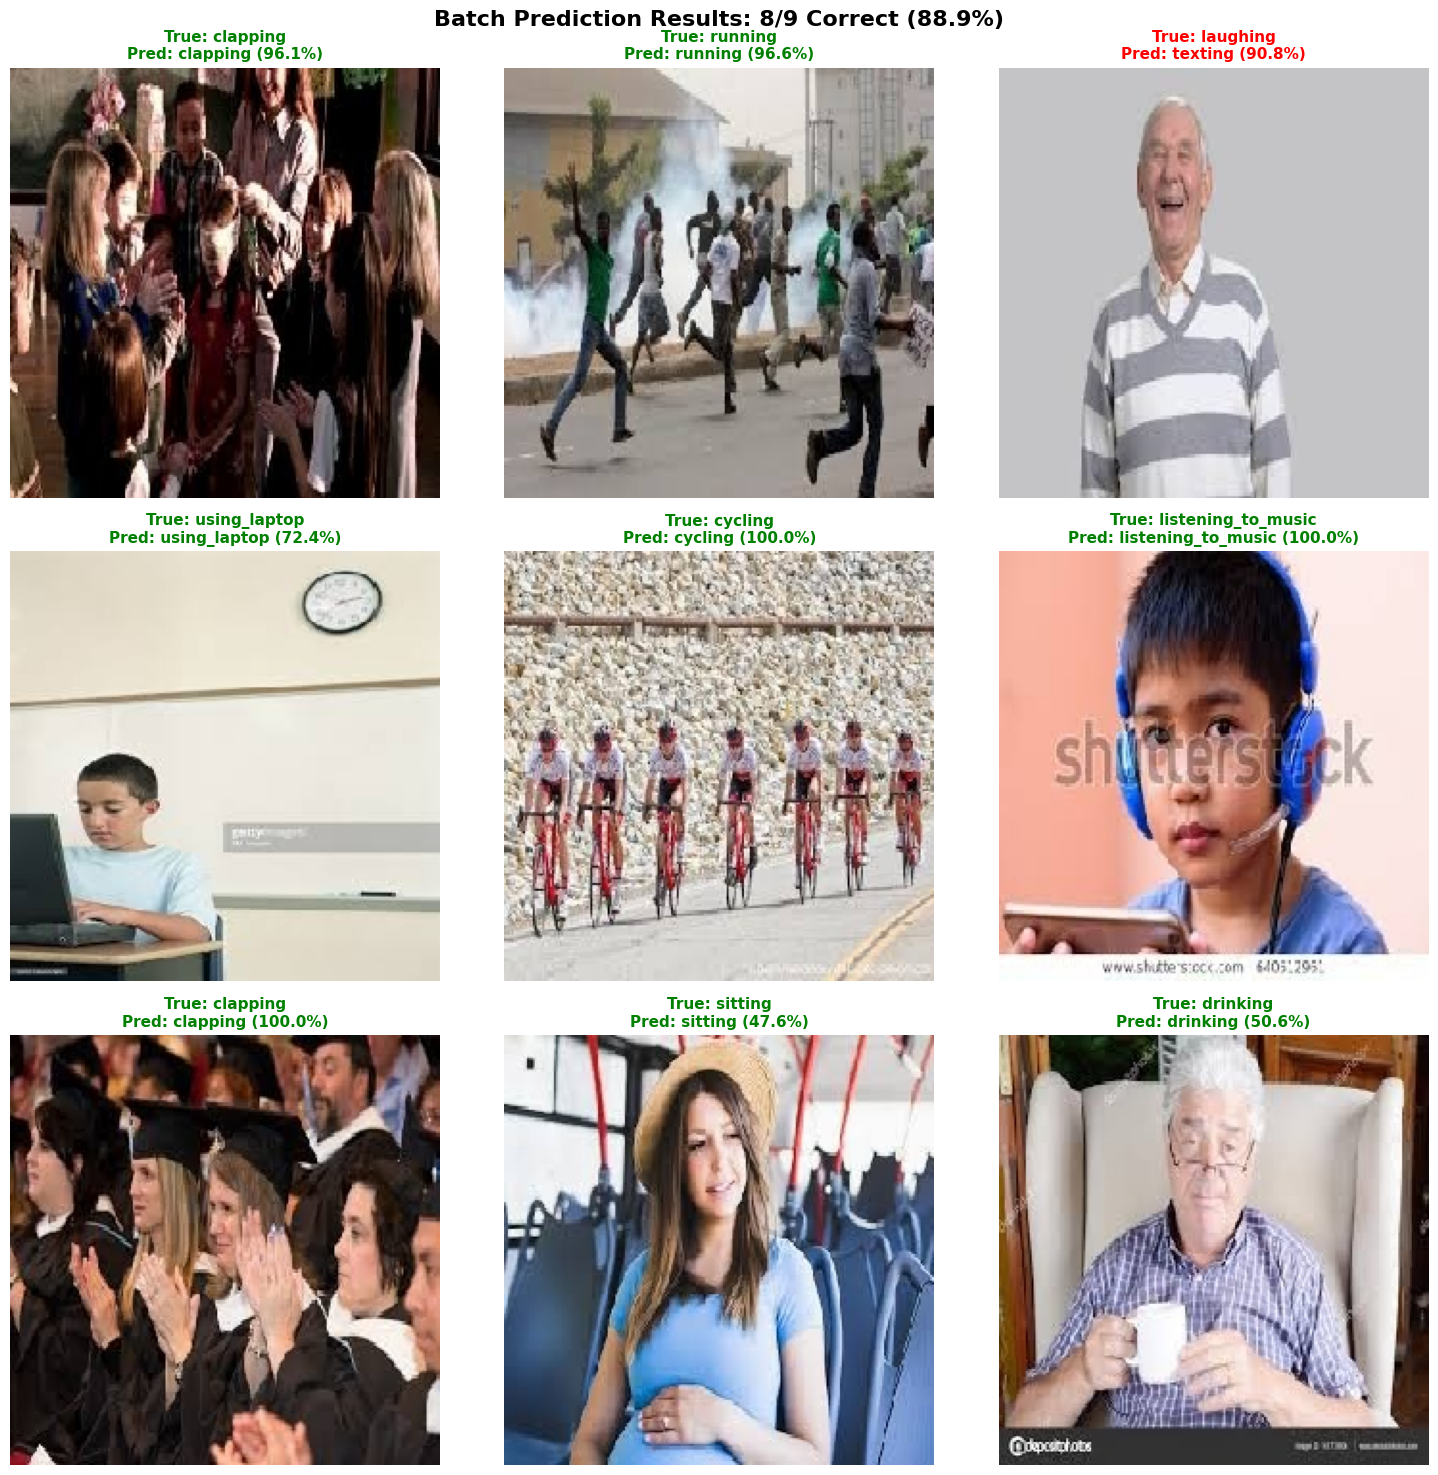

✓ Batch accuracy: 8/9 = 88.9%


In [ ]:
# ============================================================================
# OPTION 2: Test on MULTIPLE random images
# ============================================================================
print("\n" + "=" * 80)
print("[BATCH PREDICTION] Testing on 9 random images")
print("=" * 80)

num_samples = 9
random_indices = np.random.choice(len(X_test_paths), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

correct = 0
for idx, test_idx in enumerate(random_indices):
    test_path = X_test_paths[test_idx]
    true_label = label_encoder.classes_[y_test[test_idx]]

    # Load and preprocess
    img = load_img(test_path, target_size=(Config.IMG_SIZE_DL, Config.IMG_SIZE_DL))
    img_array = img_to_array(img)
    img_array_processed = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array_processed = np.expand_dims(img_array_processed, axis=0)

    # Predict
    pred = dl_model.predict(img_array_processed, verbose=0)
    pred_class = label_encoder.classes_[np.argmax(pred)]
    conf = np.max(pred) * 100

    # Check if correct
    is_correct = (pred_class == true_label)
    if is_correct:
        correct += 1

    # Plot
    axes[idx].imshow(img)
    color = 'green' if is_correct else 'red'
    axes[idx].set_title(f"True: {true_label}\nPred: {pred_class} ({conf:.1f}%)",
                        fontsize=11, color=color, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle(f"Batch Prediction Results: {correct}/{num_samples} Correct ({correct/num_samples*100:.1f}%)",
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/kaggle/working/batch_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Batch accuracy: {correct}/{num_samples} = {correct/num_samples*100:.1f}%")



[CUSTOM IMAGE] Test on your own image
To test on a specific image, use this code:
Predicted: hugging (100.00%)


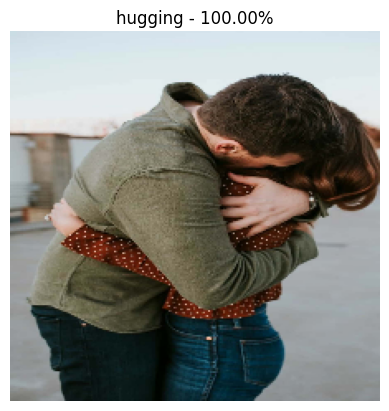

In [ ]:
# ============================================================================
# OPTION 3: Test on SPECIFIC image path (if you have one)
# ============================================================================
print("\n" + "=" * 80)
print("[CUSTOM IMAGE] Test on your own image")
print("=" * 80)
print("To test on a specific image, use this code:")

# Example usage:
specific_image_path = "/kaggle/input/hugging-pic/hug-pictures-8d9acrrst4w2xkqe.jpg"

img = load_img(specific_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

predictions = dl_model.predict(img_array, verbose=0)
predicted_class = label_encoder.classes_[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.imshow(img)
plt.title(f"{predicted_class} - {confidence:.2f}%")
plt.axis('off')
plt.show()

